In [38]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils import data

import random, os, pathlib, time
from tqdm import tqdm
from sklearn import datasets

In [39]:
import nflib
from nflib.flows import SequentialFlow, NormalizingFlow, ActNorm, ActNorm2D, AffineConstantFlow
import nflib.coupling_flows as icf
import nflib.inn_flow as inn
import nflib.res_flow as irf

In [40]:
from torch import distributions
from torch.distributions import MultivariateNormal

In [41]:
device = torch.device("cuda:0")
# device = torch.device("cpu")

## MNIST dataset

In [42]:
import mylibrary.datasets as datasets
# import mylibrary.nnlib as tnn

In [43]:
mnist = datasets.FashionMNIST()
# mnist.download_mnist()
# mnist.save_mnist()
train_data, train_label_, test_data, test_label_ = mnist.load()

train_data = train_data / 255.
test_data = test_data / 255.

# train_label = tnn.Logits.index_to_logit(train_label_)
train_size = len(train_label_)

In [44]:
## converting data to pytorch format
train_data = torch.Tensor(train_data)
test_data = torch.Tensor(test_data)
train_label = torch.LongTensor(train_label_)
test_label = torch.LongTensor(test_label_)

In [45]:
input_size = 784
output_size = 10

In [46]:
class MNIST_Dataset(data.Dataset):
    
    def __init__(self, data, label):
        self.data = data.reshape(-1, 1, 28, 28)
        self.label = label
        
#         self.label = mask.type(torch.float32).reshape(-1,1)
        self._shuffle_data_()
        
    def __len__(self):
        return len(self.data)
    
    def _shuffle_data_(self):
        randidx = random.sample(range(len(self.data)), k=len(self.data))
        self.data = self.data[randidx]
        self.label = self.label[randidx]
    
    def __getitem__(self, idx):
        img, lbl = self.data[idx], self.label[idx]
        return img, lbl

In [47]:
train_dataset = MNIST_Dataset(train_data, train_label)
test_dataset = MNIST_Dataset(test_data, test_label)

In [48]:
batch_size = 50
train_loader = data.DataLoader(dataset=train_dataset, num_workers=4, batch_size=batch_size, shuffle=True)
test_loader = data.DataLoader(dataset=test_dataset, num_workers=4, batch_size=batch_size, shuffle=False)

In [49]:
class ConnectedClassifier_Linear(nn.Module):
    
    def __init__(self,input_dim, num_sets, output_dim, inv_temp=1):
        super().__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.num_sets = num_sets
        self.inv_temp = nn.Parameter(torch.ones(1)*inv_temp)
        
        self.linear = nn.Linear(input_dim, num_sets)
#         self.linear.bias.data *= 0
        self.linear.weight.data *= 0.1
#         self.cls_weight = nn.Parameter(torch.randn(num_sets, output_dim)/output_dim)

        init_val = torch.randn(num_sets, output_dim)*0.01
        for ns in range(num_sets):
            init_val[ns, ns%output_dim] = 0.1
        self.cls_weight = nn.Parameter(init_val)
        
        self.cls_confidence = None
        
        
    def forward(self, x, hard=False):
#         self.cls_weight.data = torch.abs(self.cls_weight.data/self.cls_weight.data.sum(dim=1, keepdim=True))
        
        x = self.linear(x)
        if hard:
            x = torch.softmax(x*1e5, dim=1)
        else:
            x = torch.softmax(x*self.inv_temp, dim=1)
        self.cls_confidence = x
        c = torch.softmax(self.cls_weight, dim=1)
#         c = self.cls_weight
        return x@c ## since both are normalized, it is also normalized

In [50]:
class ConnectedClassifier_SoftKMeans(nn.Module):
    
    def __init__(self,input_dim, num_sets, output_dim, inv_temp=1):
        super().__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.num_sets = num_sets
        self.inv_temp = nn.Parameter(torch.ones(1)*inv_temp)
        
        self.centers = nn.Parameter(torch.rand(num_sets, input_dim)*2-1)
        
        init_val = torch.randn(num_sets, output_dim)*0.01
        for ns in range(num_sets):
            init_val[ns, ns%output_dim] = 0.1
#             init_val[ns, 0] = 2. ### initialize same class in all clusters

        self.cls_weight = nn.Parameter(init_val)
        self.cls_confidence = None
        
        
    def forward(self, x, hard=False):
        self.cls_weight.data = torch.abs(self.cls_weight.data)/self.cls_weight.data.sum(dim=1, keepdim=True)
        
        x = x[:, :self.input_dim]
        dists = torch.cdist(x, self.centers)
        dists = dists/np.sqrt(self.input_dim) ### correction to make diagonal of unit square 1 in nD space
        
        if hard:
            x = torch.softmax(-dists*1e5, dim=1)
        else:
            x = torch.softmax(-dists*self.inv_temp, dim=1)
        self.cls_confidence = x
#         c = torch.softmax(self.cls_weight, dim=1)
        c = self.cls_weight
        return x@c ## since both are normalized, it is also normalized
    
    def set_centroid_to_data_randomly(self, data_loader, model):
        indices = np.random.permutation(len(data_loader.dataset.data))[:self.centers.shape[0]]
        xx = data_loader.dataset.data[indices].to(self.centers.device)
        yy = data_loader.dataset.label[indices].to(self.centers.device)
        yout = model(xx)
        self.centers.data = yout
        
        init_val = torch.ones(self.num_sets, self.output_dim)/self.output_dim
        for ns in range(len(indices)):
            init_val[ns, yy[ns]] = 1.
        self.cls_weight.data = init_val.to(self.cls_weight.device)
        pass

In [51]:
# actf = nn.SELU
# flows = [
#     nn.Conv2d(1, 32, kernel_size=3, padding=1, bias=False),
#     nn.BatchNorm2d(32),
#     actf(),
#     nn.Conv2d(32, 64, kernel_size=5, padding=2, bias=False),
#     nn.BatchNorm2d(64),
#     actf(),
#     nn.Conv2d(64, 64, kernel_size=5, padding=2, bias=False),
#     nn.BatchNorm2d(64),
#     actf(),
#     nn.Conv2d(64, 64, kernel_size=5, padding=2, bias=False),
#     nn.BatchNorm2d(64),
#     actf(),
#     nn.Conv2d(64, 1, kernel_size=5, padding=2),
#     actf(),
#     irf.Flatten(img_size=(1, 28, 28)),
#     nn.BatchNorm1d(1*28*28),
#         ]

# model = nn.Sequential(*flows)

In [52]:
# model(torch.randn(3, 1, 28, 28)).shape

In [53]:
actf = irf.Swish
flows = [
    ActNorm2D(1),
    irf.ConvResidualFlow(1, [16], activation=actf),
    irf.InvertiblePooling(2),
    ActNorm2D(4),
    irf.ConvResidualFlow(4, [64], activation=actf),
    irf.InvertiblePooling(2),
    ActNorm2D(16),
    irf.ConvResidualFlow(16, [64, 64], activation=actf),
    irf.Flatten(img_size=(16, 7, 7)),
    ActNorm(16*7*7),
        ]

model = SequentialFlow(flows)

In [54]:
# actf = irf.Swish
# flows = [
#     nn.BatchNorm2d(1),
#     irf.ConvResidualFlow(1, [16], activation=actf),
#     irf.InvertiblePooling(2),
#     nn.BatchNorm2d(4),
#     irf.ConvResidualFlow(4, [64], activation=actf),
#     irf.InvertiblePooling(2),
#     nn.BatchNorm2d(16),
#     irf.ConvResidualFlow(16, [64, 64], activation=actf),
#     irf.Flatten(img_size=(16, 7, 7)),
#     nn.BatchNorm1d(16*7*7),
#         ]

# model = nn.Sequential(*flows)

In [55]:
def get_children(module):
    child = list(module.children())
    if len(child) == 0:
        return [module]
    children = []
    for ch in child:
        grand_ch = get_children(ch)
        children+=grand_ch
    return children

In [56]:
def remove_spectral_norm(model):
    for child in get_children(model):
        if hasattr(child, 'weight'):
            print("Yes", child)
            try:
                nn.utils.remove_spectral_norm(child)
                print("Success")
            except:
                print("Failed")

In [57]:
# remove_spectral_norm(model)

In [58]:
# model = nn.Sequential(nn.Linear(784, 784, bias=False),
#                       nn.BatchNorm1d(784),
#                       nn.SELU(),
#                       nn.Linear(784, 784, bias=False),
#                       nn.BatchNorm1d(784),
#                       nn.SELU(),
#                      )

In [59]:
model.to(device)

SequentialFlow(
  (flows): ModuleList(
    (0): ActNorm2D()
    (1): ConvResidualFlow(
      (resblock): ModuleList(
        (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): Swish()
        (2): Conv2d(16, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
    )
    (2): InvertiblePooling()
    (3): ActNorm2D()
    (4): ConvResidualFlow(
      (resblock): ModuleList(
        (0): Conv2d(4, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): Swish()
        (2): Conv2d(64, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
    )
    (5): InvertiblePooling()
    (6): ActNorm2D()
    (7): ConvResidualFlow(
      (resblock): ModuleList(
        (0): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): Swish()
        (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): Swish()
        (4): Conv2d(64, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )


In [60]:
xx = iter(test_loader).next()[0]
model(xx.to(device)).shape

torch.Size([50, 784])

In [61]:
for p in model.parameters():
    print(p.device)
    break

cuda:0


In [62]:
# actf = irf.Swish
# _flows = [
#     ActNorm(2),
#     irf.ResidualFlow(2, [20, 20], activation=actf),
#     ActNorm(2),
#         ]
# _clasf = SequentialFlow(_flows)
# _clasf = nn.Sequential(nn.Linear(784, 2), _clasf)

classifier = nn.Sequential(
                nn.Linear(784, 2),
#                 _clasf,
                ConnectedClassifier_SoftKMeans(2,20 , 10)
#                 ConnectedClassifier_Linear(2, 100, 10)
            )

In [63]:
# classifier = ConnectedClassifier_SoftKMeans(784, 100, 10)
# classifier = ConnectedClassifier_Softmax(784, 100, 10)
classifier = classifier.to(device)

## Model Train

In [64]:
classifier[1].set_centroid_to_data_randomly(train_loader, nn.Sequential(model, classifier[0]))

In [65]:
class EMA(object):

    def __init__(self, momentum=0.98, mu=None):
        self.mu = mu
        self.momentum = momentum

    def __call__(self, x):
        if self.mu is None:
            self.mu = x
        self.mu = self.momentum*self.mu + (1.0 - self.momentum)*x
        return self.mu
    
    def __repr__(self):
        rep = f"mu=[{self.mu}]"
        return rep

In [66]:
def relocate_centroids(num_samples=20000):
    count_samples = 0
    xxs = []
#     index_per_cls = []
    index_per_cls = [EMA(0.98) for i in range(classifier[1].num_sets)]
    for i in range(len(classifier[1].centers)):
        index_per_cls[i].mu = classifier[1].centers.data[i]
    
    print("Relocating Centroids")
    for xx, yy in tqdm(train_loader):
        count_samples += len(xx)
        xx, yy = xx.to(device), yy.to(device) 
        yout = classifier[0](model(xx))
        _ = classifier[1](yout) 
        
        cls_indx = torch.argmax(classifier[1].cls_confidence, dim=1)
#         set_indx, count = torch.unique(cls_indx, return_counts=True)
        for ci in cls_indx:
            index_per_cls[ci](yout[ci].data)
    
        if count_samples>num_samples:
            break
    
    for i in range(len(classifier[1].centers)):
        if index_per_cls[i].mu is not None:
            classifier[1].centers.data[i] = index_per_cls[i].mu.data
    
#     print(classifier[1].centers)
    return

In [67]:
# relocate_centroids()

In [68]:
learning_rate = 0.0003

In [69]:
# criterion = nn.NLLLoss()
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(list(model.parameters())+list(classifier.parameters()), lr=learning_rate)
# optimizer = optim.SGD(model.parameters(), lr=0.1)

print("number of params: ", sum(p.numel() for p in model.parameters()))

number of params:  62035


In [70]:
# for p in model.parameters():
#     print(torch.isnan(p).type(torch.float32).sum())

In [71]:
# model(torch.randn(10, 784).to(device)).shape

In [72]:
xx = iter(test_loader).next()[0]
xx.shape

torch.Size([50, 1, 28, 28])

In [73]:
losses = []
train_accs = []
test_accs = []
EPOCHS = 50

In [74]:
index = 0
for epoch in range(EPOCHS):
    train_acc = 0
    train_count = 0
    if (epoch+1)%5 == 0:
        model.eval()
        relocate_centroids()
    model.train()
    for xx, yy in tqdm(train_loader):
        xx, yy = xx.to(device), yy.to(device)
#     for xx, yy in tqdm(test_loader):

        yout = model(xx)
#         print(yout)
        yout = classifier(yout)    
#         print(yout)
        loss = criterion(yout, yy)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(float(loss))

        outputs = torch.argmax(yout, dim=1).data.cpu().numpy()
        correct = (outputs == yy.data.cpu().numpy()).astype(float).sum()
        train_acc += correct
        train_count += len(outputs)
#         break

    train_accs.append(float(train_acc)/train_count*100)
    train_acc = 0
    train_count = 0

    print(f'Epoch: {epoch}:{index},  Loss:{float(loss)}')
    test_count = 0
    test_acc = 0
    model.eval()
    for xx, yy in tqdm(test_loader):
        xx, yy = xx.to(device), yy.to(device)
        with torch.no_grad():
            yout = classifier(model(xx))    
        outputs = torch.argmax(yout, dim=1).data.cpu().numpy()
        correct = (outputs == yy.data.cpu().numpy()).astype(float).sum()
        test_acc += correct
        test_count += len(xx)
    test_accs.append(float(test_acc)/test_count*100)
    print(f'Train Acc:{train_accs[-1]:.2f}%, Test Acc:{test_accs[-1]:.2f}%')
    print()

### after each class index is finished training
print(f'\t-> Train Acc {max(train_accs)} ; Test Acc {max(test_accs)}')

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 0:0,  Loss:2.1780550479888916


  0%|          | 0/1200 [00:00<?, ?it/s]

Train Acc:40.88%, Test Acc:45.11%



  0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 1:0,  Loss:2.046116352081299


  0%|          | 0/1200 [00:00<?, ?it/s]

Train Acc:50.28%, Test Acc:51.77%



  0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 2:0,  Loss:1.9871684312820435


  0%|          | 0/1200 [00:00<?, ?it/s]

Train Acc:52.52%, Test Acc:54.37%



  0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 3:0,  Loss:1.9158776998519897


  0%|          | 0/1200 [00:00<?, ?it/s]

Train Acc:56.66%, Test Acc:58.95%

Relocating Centroids


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 4:0,  Loss:2.059691905975342


  0%|          | 0/1200 [00:00<?, ?it/s]

Train Acc:49.21%, Test Acc:59.66%



  0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 5:0,  Loss:1.999780297279358


  0%|          | 0/1200 [00:00<?, ?it/s]

Train Acc:56.93%, Test Acc:57.18%



  0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 6:0,  Loss:1.8419476747512817


  0%|          | 0/1200 [00:00<?, ?it/s]

Train Acc:57.55%, Test Acc:57.58%



  0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 7:0,  Loss:1.8142454624176025


  0%|          | 0/1200 [00:00<?, ?it/s]

Train Acc:57.89%, Test Acc:57.67%



  0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 8:0,  Loss:1.848786473274231


  0%|          | 0/1200 [00:00<?, ?it/s]

Train Acc:58.11%, Test Acc:57.76%

Relocating Centroids


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 9:0,  Loss:1.8930217027664185


  0%|          | 0/1200 [00:00<?, ?it/s]

Train Acc:51.69%, Test Acc:56.73%



  0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 10:0,  Loss:1.9170958995819092


  0%|          | 0/1200 [00:00<?, ?it/s]

Train Acc:57.98%, Test Acc:57.77%



  0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 11:0,  Loss:1.8637864589691162


  0%|          | 0/1200 [00:00<?, ?it/s]

Train Acc:59.66%, Test Acc:62.74%



  0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 12:0,  Loss:1.846530556678772


  0%|          | 0/1200 [00:00<?, ?it/s]

Train Acc:63.28%, Test Acc:63.22%



  0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 13:0,  Loss:1.868039608001709


  0%|          | 0/1200 [00:00<?, ?it/s]

Train Acc:64.33%, Test Acc:64.01%

Relocating Centroids


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 14:0,  Loss:1.915489673614502


  0%|          | 0/1200 [00:00<?, ?it/s]

Train Acc:53.22%, Test Acc:56.83%



  0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 15:0,  Loss:1.8672478199005127


  0%|          | 0/1200 [00:00<?, ?it/s]

Train Acc:57.57%, Test Acc:57.47%



  0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 16:0,  Loss:1.8660203218460083


  0%|          | 0/1200 [00:00<?, ?it/s]

Train Acc:57.87%, Test Acc:56.93%



  0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 17:0,  Loss:1.9161776304244995


  0%|          | 0/1200 [00:00<?, ?it/s]

Train Acc:57.90%, Test Acc:57.52%



  0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 18:0,  Loss:1.8763922452926636


  0%|          | 0/1200 [00:00<?, ?it/s]

Train Acc:58.07%, Test Acc:57.60%

Relocating Centroids


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 19:0,  Loss:1.982755184173584


  0%|          | 0/1200 [00:00<?, ?it/s]

Train Acc:46.74%, Test Acc:47.35%



  0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 20:0,  Loss:2.0645453929901123


  0%|          | 0/1200 [00:00<?, ?it/s]

Train Acc:48.23%, Test Acc:47.41%



  0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 21:0,  Loss:2.013350486755371


  0%|          | 0/1200 [00:00<?, ?it/s]

Train Acc:48.07%, Test Acc:47.26%



  0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 22:0,  Loss:2.046527624130249


  0%|          | 0/1200 [00:00<?, ?it/s]

Train Acc:48.16%, Test Acc:48.05%



  0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 23:0,  Loss:1.9378652572631836


  0%|          | 0/1200 [00:00<?, ?it/s]

Train Acc:48.08%, Test Acc:47.58%

Relocating Centroids


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 24:0,  Loss:2.00774884223938


  0%|          | 0/1200 [00:00<?, ?it/s]

Train Acc:47.12%, Test Acc:49.90%



  0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 25:0,  Loss:1.879012107849121


  0%|          | 0/1200 [00:00<?, ?it/s]

Train Acc:57.14%, Test Acc:57.51%



  0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 26:0,  Loss:1.911009669303894


  0%|          | 0/1200 [00:00<?, ?it/s]

Train Acc:58.45%, Test Acc:57.79%



  0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 27:0,  Loss:1.8180586099624634


  0%|          | 0/1200 [00:00<?, ?it/s]

Train Acc:58.37%, Test Acc:58.03%



  0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 28:0,  Loss:1.836094856262207


  0%|          | 0/1200 [00:00<?, ?it/s]

Train Acc:58.42%, Test Acc:57.43%

Relocating Centroids


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 29:0,  Loss:1.8293297290802002


  0%|          | 0/1200 [00:00<?, ?it/s]

Train Acc:49.45%, Test Acc:57.25%



  0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 30:0,  Loss:1.9160127639770508


  0%|          | 0/1200 [00:00<?, ?it/s]

Train Acc:58.27%, Test Acc:57.65%



  0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 31:0,  Loss:1.8783153295516968


  0%|          | 0/1200 [00:00<?, ?it/s]

Train Acc:58.55%, Test Acc:57.72%



  0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 32:0,  Loss:1.9035301208496094


  0%|          | 0/1200 [00:00<?, ?it/s]

Train Acc:58.28%, Test Acc:57.69%



  0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 33:0,  Loss:1.9124984741210938


  0%|          | 0/1200 [00:00<?, ?it/s]

Train Acc:58.40%, Test Acc:57.65%

Relocating Centroids


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 34:0,  Loss:1.9648752212524414


  0%|          | 0/1200 [00:00<?, ?it/s]

Train Acc:44.37%, Test Acc:60.91%



  0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 35:0,  Loss:1.8742390871047974


  0%|          | 0/1200 [00:00<?, ?it/s]

Train Acc:62.86%, Test Acc:62.37%



  0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 36:0,  Loss:1.885719895362854


  0%|          | 0/1200 [00:00<?, ?it/s]

Train Acc:64.18%, Test Acc:63.27%



  0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 37:0,  Loss:1.8897262811660767


  0%|          | 0/1200 [00:00<?, ?it/s]

Train Acc:64.78%, Test Acc:63.35%



  0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 38:0,  Loss:1.824887752532959


  0%|          | 0/1200 [00:00<?, ?it/s]

Train Acc:65.35%, Test Acc:63.54%

Relocating Centroids


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 39:0,  Loss:1.9973598718643188


  0%|          | 0/1200 [00:00<?, ?it/s]

Train Acc:33.26%, Test Acc:46.50%



  0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 40:0,  Loss:1.928097128868103


  0%|          | 0/1200 [00:00<?, ?it/s]

Train Acc:48.67%, Test Acc:52.73%



  0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 41:0,  Loss:1.9250383377075195


  0%|          | 0/1200 [00:00<?, ?it/s]

Train Acc:53.78%, Test Acc:51.77%



  0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 42:0,  Loss:1.9029905796051025


  0%|          | 0/1200 [00:00<?, ?it/s]

Train Acc:53.98%, Test Acc:53.73%



  0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 43:0,  Loss:1.9642962217330933


  0%|          | 0/1200 [00:00<?, ?it/s]

Train Acc:54.71%, Test Acc:53.41%

Relocating Centroids


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 44:0,  Loss:1.9761052131652832


  0%|          | 0/1200 [00:00<?, ?it/s]

Train Acc:47.88%, Test Acc:51.42%



  0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 45:0,  Loss:1.901015043258667


  0%|          | 0/1200 [00:00<?, ?it/s]

Train Acc:54.26%, Test Acc:52.72%



  0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 46:0,  Loss:1.9162794351577759


  0%|          | 0/1200 [00:00<?, ?it/s]

Train Acc:54.52%, Test Acc:53.40%



  0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 47:0,  Loss:1.914077639579773


  0%|          | 0/1200 [00:00<?, ?it/s]

Train Acc:54.99%, Test Acc:53.96%



  0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 48:0,  Loss:1.9760252237319946


  0%|          | 0/1200 [00:00<?, ?it/s]

Train Acc:55.18%, Test Acc:54.07%

Relocating Centroids


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 49:0,  Loss:1.9864639043807983


100%|██████████| 200/200 [00:00<00:00, 324.81it/s]

Train Acc:45.81%, Test Acc:52.72%

	-> Train Acc 65.35 ; Test Acc 64.01


In [38]:
aasfsdfsf
classifier[1].inv_temp#, classifier[1].power 

NameError: name 'aasfsdfsf' is not defined

### Hard test accuracy with count per classifier

In [39]:
model.eval()

Sequential(
  (0): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (1): ConvResidualFlow(
    (resblock): ModuleList(
      (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): Swish()
      (2): Conv2d(16, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
  )
  (2): InvertiblePooling()
  (3): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (4): ConvResidualFlow(
    (resblock): ModuleList(
      (0): Conv2d(4, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): Swish()
      (2): Conv2d(64, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
  )
  (5): InvertiblePooling()
  (6): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): ConvResidualFlow(
    (resblock): ModuleList(
      (0): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): Swish()
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1

In [40]:
test_count = 0
test_acc = 0
# set_count = torch.zeros(classifier.num_sets).to(device)
set_count = torch.zeros(classifier[1].num_sets).to(device)
for xx, yy in tqdm(test_loader):
    xx, yy = xx.to(device), yy.to(device)
    with torch.no_grad():
#         yout = classifier(model(xx), hard=True)
        yout = classifier[1](classifier[0](model(xx)), hard=True)
    
#         set_indx, count = torch.unique(torch.argmax(classifier.cls_confidence, dim=1), return_counts=True) 
        set_indx, count = torch.unique(torch.argmax(classifier[1].cls_confidence, dim=1), return_counts=True)
    
        set_count[set_indx] += count
    outputs = torch.argmax(yout, dim=1).data.cpu().numpy()
    correct = (outputs == yy.data.cpu().numpy()).astype(float).sum()
    test_acc += correct
    test_count += len(xx)

print(f'Hard Test Acc:{float(test_acc)/test_count*100:.2f}%')
print(set_count.type(torch.long).tolist())

100%|██████████| 200/200 [00:04<00:00, 41.18it/s]

Hard Test Acc:36.37%
[7, 2930, 9, 1, 7, 93, 2961, 0, 16, 969, 0, 2990, 1, 16, 0]


In [41]:
#### Classifiers that enclose any data
torch.count_nonzero(set_count)

tensor(12, device='cuda:0')

In [42]:
embeddings, labels, ilabels = [], [], []
model.eval()
for xx, yy in tqdm(test_loader):
    ilabels.append(yy)
    xx, yy = xx.to(device), yy.to(device)
    with torch.no_grad():
#         yout = classifier(model(xx), hard=True)
        embs = classifier[0](model(xx))
        embeddings.append(embs.cpu())
        
        yout = classifier[1](embs, hard=True)
        labels.append(torch.argmax(yout, dim=1).cpu())
        
        
    

embeddings = torch.cat(embeddings, dim=0)
labels = torch.cat(labels, dim=0)
ilabels = torch.cat(ilabels, dim=0)
# maxims = torch.cat(maxims, dim=0)

100%|██████████| 200/200 [00:05<00:00, 39.34it/s]


In [43]:
## Plot scatter plot of images
# https://nextjournal.com/ml4a/image-t-sne

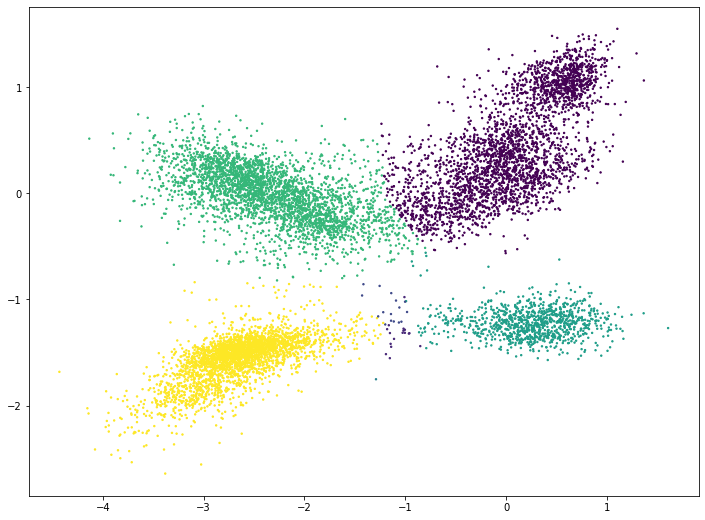

In [44]:
plt.figure(figsize=(12,9))
plt.scatter(embeddings[:,0], embeddings[:, 1], c=labels, s=2)
# plt.savefig('./output/01_prediction.pdf')

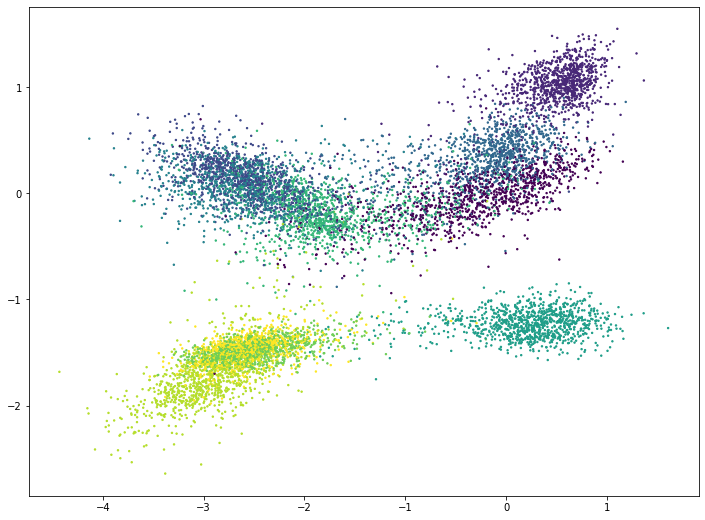

In [45]:
plt.figure(figsize=(12,9))
plt.scatter(embeddings[:,0], embeddings[:, 1], c=ilabels, s=2)
# plt.savefig('./output/02_ground_truth.pdf')

In [46]:
torch.count_nonzero(labels==ilabels)

tensor(3637)

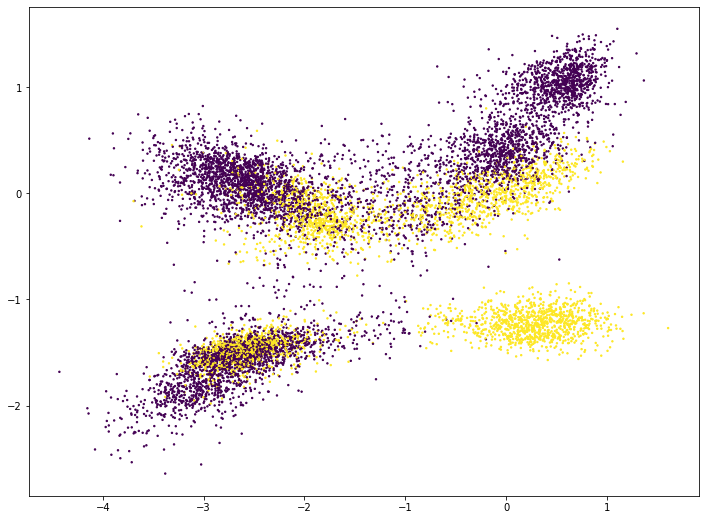

In [47]:
### Error Nodes
plt.figure(figsize=(12,9))
plt.scatter(embeddings[:,0], embeddings[:, 1], c=(labels==ilabels), s=2)
# plt.savefig('./output/03_errors.pdf')

In [48]:
## plot on a 2D map, the decision boundary
ng = 1000
_a,_b,_c,_d = embeddings[:,0].min()-0.1, embeddings[:,0].max()+0.1, embeddings[:,1].min()-0.1, embeddings[:,1].max()+0.1
xg, yg = torch.linspace(_a, _b, ng), torch.linspace(_c, _d, ng)
xg, yg = torch.meshgrid(xg, yg)
xyg = torch.stack([xg.reshape(-1), yg.reshape(-1)], dim=-1)

In [49]:
xyg.shape

torch.Size([1000000, 2])

In [50]:
BS = 1000
output, maxims = [], []
for i in range(0, len(xyg), BS):
    xx = xyg[i:i+BS].to(device)
    with torch.no_grad():
        yout = classifier[1](xx, hard=True)
        output.append(torch.argmax(yout, dim=1).cpu())
        
        dists = torch.cdist(xx, classifier[1].centers)
        dists = dists/np.sqrt(classifier[1].input_dim) ### correction to make diagonal of unit square 1 in nD space

        mask = torch.argmin(dists, dim=1) ## reusing embs.. it is one hot to select distance
        mask = dists[torch.arange(len(mask), dtype=torch.long), mask]
        maxims.append((mask*classifier[1].inv_temp).cpu())
        


output = torch.cat(output, dim=0)
maxims = torch.cat(maxims, dim=0)

In [51]:
# maxims.shape

In [52]:
# xyg[:,0].reshape(xg.shape).shape,xyg[:,1].reshape(yg.shape).shape, maxims.reshape(xg.shape).shape

/home/tsuman/Program_Files/Python/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  """


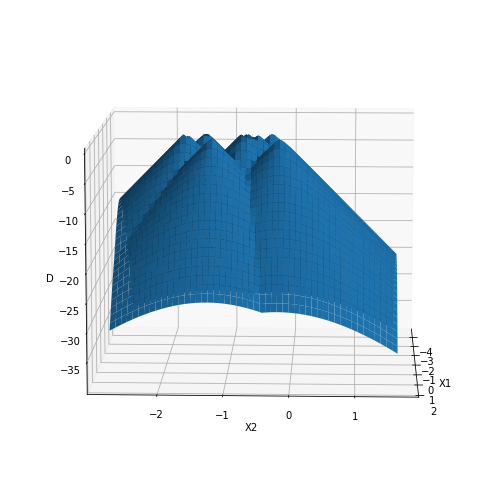

In [53]:
## plot 3D for the distance
%matplotlib inline
fig = plt.figure(figsize=(11,9))

ax = fig.gca(projection='3d')
ax.view_init(elev=10., azim=2)
ax.plot_surface(xyg[:,0].numpy().reshape(xg.shape),
                xyg[:,1].numpy().reshape(yg.shape),
                -maxims.cpu().numpy().reshape(xg.shape))
    
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('D')
plt.show()

In [54]:
# plt.figure(figsize=(12,9))
# plt.scatter(embeddings[:,0], embeddings[:, 1], c=ilabels, s=2, cmap='tab10')
# cf = plt.contourf(xyg[:,0].reshape(xg.shape),
#                  xyg[:,1].reshape(yg.shape),
#                  output.reshape(xg.shape), levels=9,
#                  alpha=0.5, cmap="tab10", antialiased=True)

In [55]:
### plot centroids as well

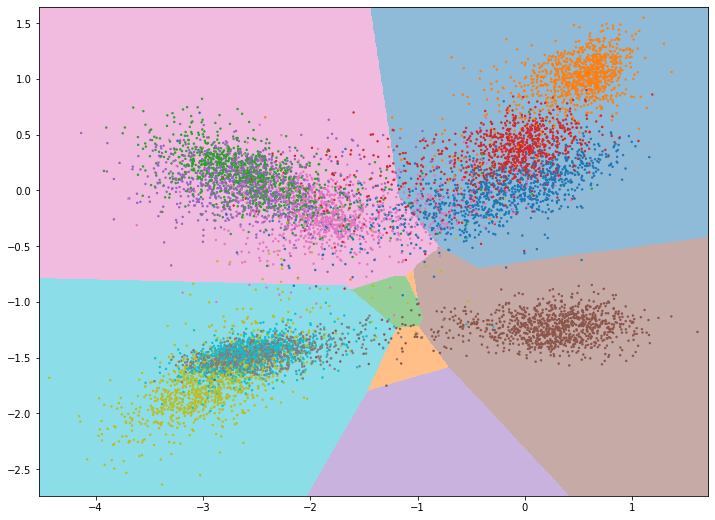

In [56]:
plt.figure(figsize=(12,9))
plt.scatter(embeddings[:,0], embeddings[:, 1], c=ilabels, s=2, cmap='tab10')
plt.imshow(output.reshape(xg.shape).t(), interpolation='nearest',
           extent=(_a, _b, _c, _d),
           alpha=0.5, cmap='tab10',
           aspect='auto', origin='lower')

# plt.savefig('./output/04_DecisionBoundary_Class.pdf')

In [57]:
## display different class boundary

BS = 1000
output2 = []
for i in range(0, len(xyg), BS):
    xx = xyg[i:i+BS].to(device)
    with torch.no_grad():
        yout = classifier[1](xx, hard=True)
        output2.append(torch.argmax(classifier[1].cls_confidence, dim=1).cpu())
output2 = torch.cat(output2, dim=0)

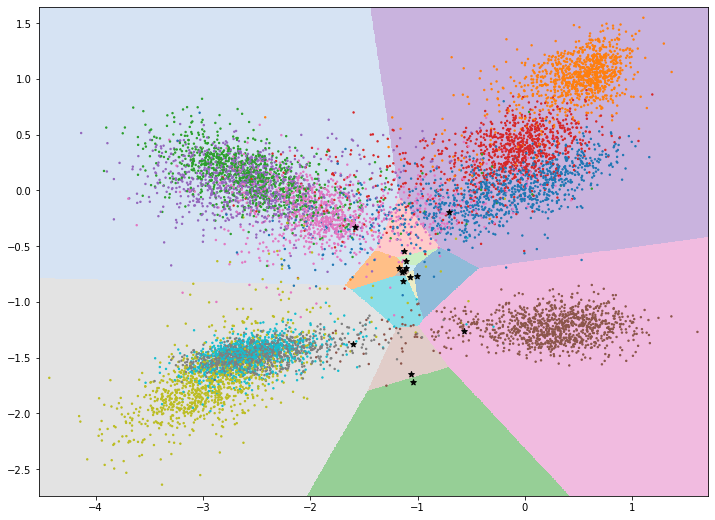

In [58]:
plt.figure(figsize=(12,9))
plt.scatter(embeddings[:,0], embeddings[:, 1], c=ilabels, s=2, cmap='tab10')
plt.imshow(output2.reshape(xg.shape).t(), interpolation='nearest',
           extent=(_a, _b, _c, _d),
           alpha=0.5, cmap='tab20',
           aspect='auto', origin='lower')
### plot centroids as well
plt.scatter(*classifier[1].centers.data.cpu().numpy().T, marker='*', c='k')

# plt.savefig('./output/05_DecisionBoundary_Sets.pdf')

### Hard train accuracy with count per classifier

In [ ]:
test_count = 0
test_acc = 0
# set_count = torch.zeros(classifier.num_sets).to(device)
set_count = torch.zeros(classifier[1].num_sets).to(device)
for xx, yy in tqdm(train_loader):
    xx, yy = xx.to(device), yy.to(device)
    with torch.no_grad():
#         yout = classifier(model(xx), hard=True)
        yout = classifier[1](classifier[0](model(xx)), hard=True)
        
#         set_indx, count = torch.unique(torch.argmax(classifier.cls_confidence, dim=1), return_counts=True) 
        set_indx, count = torch.unique(torch.argmax(classifier[1].cls_confidence, dim=1), return_counts=True) 
        set_count[set_indx] += count
    outputs = torch.argmax(yout, dim=1).data.cpu().numpy()
    correct = (outputs == yy.data.cpu().numpy()).astype(float).sum()
    test_acc += correct
    test_count += len(xx)

print(f'Hard Train Acc:{float(test_acc)/test_count*100:.2f}%')
print(set_count.type(torch.long).tolist())

In [ ]:
#### Classifiers that enclose any data
torch.count_nonzero(set_count)

In [ ]:
#### classifier with class representation
torch.argmax(classifier.cls_weight, dim=1)

In [ ]:
# The class labels are same as that of initialized
# tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3,
#         4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7,
#         8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1,
#         2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5,
#         6, 7, 8, 9], device='cuda:0')

In [ ]:
classifier.cls_weight

In [ ]:
# torch.unique(torch.argmax(classifier.cls_confidence, dim=1), return_counts=True)

In [ ]:
classifier.inv_temp

In [ ]:
### example output per classifier
yout[5]

In [ ]:
asdfsdf ## to break the code

### analyze per classifier accuracy

In [ ]:
test_count = 0
test_acc = 0
set_count = torch.zeros(classifier.num_sets).to(device)
set_acc = torch.zeros(classifier.num_sets).to(device)
for xx, yy in tqdm(train_loader):
    xx, yy = xx.to(device), yy.to(device)
    with torch.no_grad():
        yout = classifier(model(xx), hard=True)
        
    cls_indx = torch.argmax(classifier.cls_confidence, dim=1)
    set_indx, count = torch.unique(cls_indx, return_counts=True) 
    set_count[set_indx] += count
    
    outputs = torch.argmax(yout, dim=1).data.cpu().numpy()
    correct = (outputs == yy.data.cpu().numpy()).astype(float)
    
    ### class_index has 100 possible values
    for i, c in enumerate(correct):
        set_acc[cls_indx[i]] += c
    
#     print(set_acc.sum(), set_count.sum())
#     break
    test_acc += correct.sum()
    test_count += len(xx)

print(f'Hard Train Acc:{float(test_acc)/test_count*100:.2f}%')
print(set_count.type(torch.long).tolist())

In [ ]:
set_acc/set_count

In [ ]:
for i, (cnt, acc, cls) in enumerate(zip(set_count.type(torch.long).tolist(),
                                   (set_acc/set_count).tolist(),
                                   torch.argmax(classifier.cls_weight, dim=1).tolist())):
    if cnt == 0: continue
    print(f"{i},\t {cnt},\t {cls}\t {acc*100:.2f}%")

### Benchmark - Robustness

In [ ]:
import foolbox as fb
import foolbox.attacks as fa

In [ ]:
epsilons = [0.001, 0.01, 0.03, 0.1, 0.3, 0.5, 1.0]
# epsilons = [0.0005, 0.001, 0.0015, 0.002, 0.003, 0.005, 0.01, 0.02, 0.03, 0.1, 0.3, 0.5, 1.0,]

#### Benchmark on full dataset

In [ ]:
attacks = [
    fa.FGSM(),
    fa.LinfPGD(),
    fa.LinfBasicIterativeAttack(),
#     fa.LinfAdditiveUniformNoiseAttack(),
#     fa.LinfDeepFoolAttack(),
]
atk_names = [
    "FGSM", 
    "LinfPGD", 
    "LinfBasicIterativeAttack", 
#     "LinfAdditiveUniformNoiseAttack", 
#     "LinfDeepFoolAttack",
]

In [ ]:
def get_attack_success(model, attack, dataloader):
    fmodel = fb.PyTorchModel(model.eval(), bounds=(-1, 1), device=device)
    success_per_eps = []

    for eps in epsilons:
        count = 0
        total = 0
        print(f"Running one epoch attack for eps: {eps}")
        for i, (images, labels) in enumerate(tqdm(dataloader)):
            images, labels = images.to(device), labels.to(device)
            _, _, success = attack(fmodel, images, labels, epsilons=[eps])
            count += int(torch.count_nonzero(success))
            total += torch.numel(success)
#             break
        success_per_eps.append(count/total)
    return success_per_eps

In [ ]:
# get_attack_success(model, attacks[0], test_loader)

### Compute the robustness

In [ ]:
# outputs = {}

# model_ = nn.Sequential(model, classifier)

# model_.eval()
# ### load model and compute attack_success
# for j in range(len(attacks)):
#     attack = attacks[j]
#     atname = atk_names[j]

#     print(f"Attacking on model using {atname}")
#     succ_eps = get_attack_success(model_, attack, test_loader)
#     outputs[atname] = succ_eps
#     print(f"Success rate is : {succ_eps}")

In [ ]:
torch.cuda.current_device()

In [ ]:
# torch.cuda.set_device(1)

### View the embedding space

In [ ]:
model_ = nn.Sequential(model, classifier)
fmodel = fb.PyTorchModel(model_.eval(), bounds=(-1, 1), device=device)
fmodel.device = device

attack = attacks[0]
eps = epsilons[0]
print(f"Running one epoch attack for eps: {eps}")

true_emb, attk_emb = [], []
true_lbl, attk_lbl = [], []

count = 0
total = 0

for i, (images, labels) in enumerate(tqdm(test_loader)):
    images, labels = images.to(device), labels.to(device)
    _, adv, success = attack(fmodel, images, labels, epsilons=[eps])
    count += int(torch.count_nonzero(success))
    total += torch.numel(success)
    break

In [ ]:
adv[0].shape

In [ ]:
plt.imshow(adv[0][0,0].cpu())

In [ ]:
plt.imshow(images[0,0].cpu())

In [ ]:
model_ = nn.Sequential(model, classifier)
fmodel = fb.PyTorchModel(model_.eval(), bounds=(-1, 1), device=device)
fmodel.device = device

ai = 0
attack = attacks[ai]

eps = epsilons[0]
print(f"Running one epoch attack for eps: {eps}, [{atk_names[ai]}]")


true_emb, attk_emb = [], []
true_lbl, attk_lbl = [], []

count = 0
total = 0
for xx, yy in tqdm(test_loader):
    xx, yy = xx.to(device), yy.to(device)
    embs = classifier[0](model(xx))
    
    true_emb.append(embs.data.cpu())
    
    yout = classifier[1](embs)
    true_lbl.append(torch.argmax(yout, dim=1).data.cpu())
    
    _, adv, success = attack(fmodel, xx, yy, epsilons=[eps])
    embs = classifier[0](model(adv[0]))
    attk_emb.append(embs.data.cpu())
    
    yout = classifier[1](embs)
    attk_lbl.append(torch.argmax(yout, dim=1).data.cpu())
    
    count += int(torch.count_nonzero(success))
    total += torch.numel(success)

In [ ]:
true_emb = torch.cat(true_emb, dim=0)
attk_emb = torch.cat(attk_emb, dim=0)
true_lbl = torch.cat(true_lbl, dim=0)
attk_lbl = torch.cat(attk_lbl, dim=0)

In [ ]:
print(count/total)

In [ ]:
plt.figure(figsize=(12,9))
# plt.scatter(embeddings[:,0], embeddings[:, 1], c=ilabels, s=2, cmap='tab10')
plt.imshow(output.reshape(xg.shape).t(), interpolation='nearest',
           extent=(_a, _b, _c, _d),
           alpha=0.5, cmap='tab10',
           aspect='auto', origin='lower')

plt.scatter(true_emb[:,0], true_emb[:, 1], c=attk_lbl, s=2, cmap='tab10')
# plt.scatter(attk_emb[:,0], attk_emb[:, 1], c=true_lbl, s=2, cmap='tab10')